In [19]:
# imports
import pandas as pd
import numpy as np
import csv, os ,re, glob

In [1]:
# imports
import pandas as pd
import numpy as np
import csv, os ,re, glob
import ast
from collections import Counter

import torch
from torchvision import transforms
from PIL import Image
import h5py


names = ['Sectional_Sofas', 'Sleeper_Sofas', 'Reclining_Sofas', 'LoveSeats', 'Futons', 'Settles', 'Convertibles', 
         'Accent_Chairs', 'Coffee_Tables', 'TV_Stands', 'End_Tables', 'Console_Tables', 'Ottomans', 'Living_Room_Sets', 
         'Decorative_Pillows', 'Throw_Blankets', 'Area_Rugs', 'Wall_Arts', 'Table_Lamps', 'Floor_Lamps', 
         'Pendants_and_Chandeliers', 'Sconces', 'Baskets_and_Storage', 'Candles', 'Live_Plants', 'Artificial_Plants', 
         'Planters', 'Decorative_Accessories', 'Window_Coverings', 'Decorative_Mirrors', 'Dining_Sets', 
         'Dining_Tables', 'Dining_Chairs', 'Bar_Stools', 'Kitchen_Islands', 'Buffets_and_Sideboards', 'China_Cabinets', 
         'Bakers_Recks', 'Bedroom_Sets', 'Mattresses', 'Nightstands', 'Dressers', 'Beds', 'Bedframes', 'Bases', 'Vanities', 
         'Entryway_Furnitures', 'Desks', 'Desk_Chairs', 'Bookcases', 
         'File_Cabinets', 'Computer_Armoires', 'Drafting_Tables', 'Cabinets', 'Furniture_Sets']

# 기본 경로 설정(사진들을 넣었던 폴더)
base_path = '/home/all'

# 파일 이름에서 특수문자와 숫자 제거하는 함수
def sanitize_filename(filename):
    return re.sub(r'[^a-zA-Z]', '', filename)

# 이미지 경로를 가져오는 함수
def get_image_path(title, category):
    sanitized_title = sanitize_filename(title[:200])
    file_path = os.path.join(base_path, 'imgs', category, f"{sanitized_title}.jpg")
    return file_path if os.path.exists(file_path) else "File not found."

# 모든 CSV 파일을 처리하고 하나의 데이터프레임으로 합치는 함수
def process_all_csv_files():
    all_dfs = []
    for name in names:
        csv_file = os.path.join(base_path, f'product_infos/{name}_product_infos.csv')
        if os.path.exists(csv_file):
            df = pd.read_csv(csv_file)
            df['img_path'] = df['Title'].apply(lambda title: get_image_path(title, name))
            all_dfs.append(df)
    return pd.concat(all_dfs, ignore_index=True)

# 모든 데이터를 하나의 데이터프레임으로 합치기
combined_df = process_all_csv_files()

# path에 주소가 없는 경우(크롤링이 실패한 사례)
combined_df = combined_df[combined_df['img_path'] != 'File not found.'].reset_index(drop=True)

# Style 라벨이 없으면 버리기
def extract_style(row):
    for col in ['Product_Info', 'Product_Feature']:
        try:
            info_dict = ast.literal_eval(row[col])
            if 'Style' in info_dict:
                return info_dict['Style']
            if 'style' in info_dict:
                return info_dict['style']
        except (ValueError, SyntaxError):
            continue
    return None

# Apply the function to each row
combined_df['Style'] = combined_df.apply(extract_style, axis=1)

# Drop rows where 'Style' is None
combined_df.dropna(subset=['Style'], inplace=True)


# Define valid styles
valid_styles = ['modern', 'contemporary', 'classic', 'urban', 'country', 'unique', 'minimalism']

# Modified categorize_style function
def map_style(style):
    categories = {
        "Modern": ["Modern",'Contemporary,Modern','French','Copenhagen','Modern Contemporary','Italian','Mid-Century Modern, Contemporary','Eclectic, modern, traditional','Modern, Classic', 'Modern couch','contemporary and traditional, modern','Casual, Modern','Modern, Contemporary',"Modern Minimalist", "High Gloss", "Scandinavian", "Nordic", "European", "Japanese", "Mid Century Modern",'Mid-Century Modern,Contemporary','Mid-Centuryum', "Contemporary Modern", "Minimalist Modern"],
        "Contemporary": ["Contemporary", "Streamlined", "Unadorned", "Sleek", "Understated", "Clean Lines", "Modern Contemporary", "Contemporary Chic"],
        "Classic": [ "Classic",'Classic Contemporary', "Antique", "Art Deco", "Colonial", "Baroque", "Vintage", "European", "French", "Victorian", "Traditional", "Retro","Traditional Classic", "Vintage Classic"],
        "Urban": ["Urban", "Metropolitan", "City Style", "Modern Urban", "Urban Contemporary", "Industrial", "Loft", "Modern Industrial", "Rustic Industrial", "Industrial Retro Style", "Metropolitan","Urban Industrial", "Industrial Chic",'Retro'],
        "Country": ["Country", "Rustic Country", "Country Style", "Rural", "Pastoral", "Provincial","Rustic", "Farmhouse", "Country Rustic", "Shabby Chic", "Lodge", "Reclaimed Wood","Country Rustic", "Rustic Charm"],
        "Unique": ["Unique",  "One-of-a-Kind", "Unique Design","Free Style", "Wild", "Fantasy Plus", "Boho Style", "Bohemian","Eclectic","Bohemian Eclectic", "Eclectic Mix","Fusion", "Quirky", "Galaxy", "Stars",'Bold eclectic'],
        "Minimalism": ["Minimalism", "Simple", "Zen", "Bare", "Sparse", "Minimalist","Simplistic Minimalism"]
    }

    for key, values in categories.items():
        if style in values:
            return key
    return style
 

# Simplified is_valid_style function
def is_valid_style(style):
    mapped_style = map_style(style)
    if mapped_style.lower() in valid_styles:
        return mapped_style
    else:
        return None

# Apply the function to the 'Style' column of the DataFrame
combined_df['Style'] = combined_df['Style'].apply(is_valid_style)

# Drop rows where 'Style' is None
combined_df.dropna(subset=['Style'], inplace=True)


# 분류된 갯수가 10개 미만이면 버리기
# 1. Calculate the frequency of each style
style_counts = Counter(combined_df['Style'])

# 2. Filter out styles with only ten member
combined_df = combined_df[combined_df['Style'].map(style_counts) > 10]


# img_path 와 Style 컬럼만 남기기
combined_df = combined_df[['img_path', 'Style']].reset_index(drop=True)

# save 
combined_df.to_csv('combined_df.csv', index=False)

/home/bae/miniconda3/envs/torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
combined_df = pd.read_csv('combined_df.csv')
# Count the occurrences of each unique style value
style_counts = combined_df['Style'].value_counts()
print("Counts for each Style:")
print(style_counts)


Counts for each Style:
Style
Modern          8187
Classic         1280
Contemporary     870
Country          733
Urban            455
Minimalism       159
Unique            66
Name: count, dtype: int64


Error opening image: /home/all/imgs/Sectional_Sofas/VANOMiUShapedSectionalSofaCouchCorduroyFabricModernCozyJumboSizeSeaterSofaDoubleChaiseLongueBeige.jpg


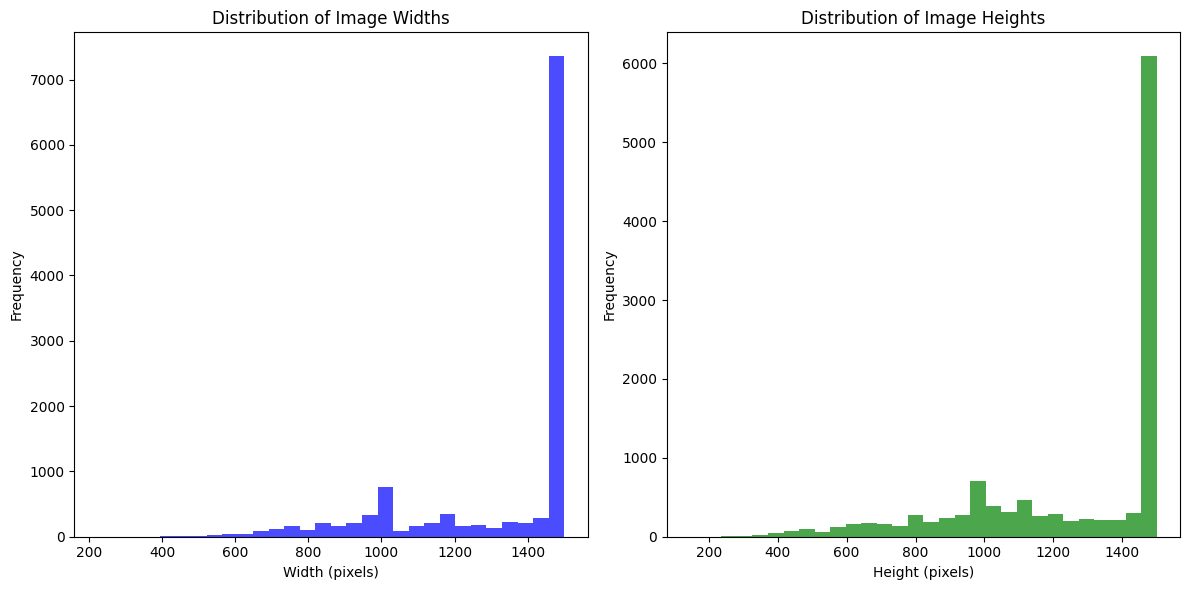

In [17]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# Lists to store the dimensions
widths = []
heights = []

# Loop through image paths and collect dimensions
for img_path in combined_df['img_path']:
    try:
        with Image.open(img_path) as img:
            width, height = img.size
            widths.append(width)
            heights.append(height)
    except IOError:
        print(f"Error opening image: {img_path}")

# Plotting the distributions
plt.figure(figsize=(12, 6))

# Distribution of widths
plt.subplot(1, 2, 1)
plt.hist(widths, bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Image Widths')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')

# Distribution of heights
plt.subplot(1, 2, 2)
plt.hist(heights, bins=30, color='green', alpha=0.7)
plt.title('Distribution of Image Heights')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [18]:
combined_df = combined_df[['img_path', 'Style']].reset_index(drop=True)
combined_df

,img_path,Style
0,/home/all/imgs/Sectional_Sofas/HONBAYModularSo...,Modern
1,/home/all/imgs/Sectional_Sofas/CHITAOversizedM...,Modern
2,/home/all/imgs/Sectional_Sofas/HONBAYModularSl...,Modern
3,/home/all/imgs/Sectional_Sofas/JUMMICOConverti...,Modern
4,/home/all/imgs/Sectional_Sofas/DevionFurniture...,Contemporary
...,...,...
11683,/home/all/imgs/Desks/YOMILUVELShapedDeskwithSt...,Modern
11684,/home/all/imgs/Desks/NeedLShapedDeskFoldingCom...,Country
11685,/home/all/imgs/Desks/SEDETALShapedDeskConverti...,Country
11686,/home/all/imgs/Desks/TribesignsInchesExecutive...,Modern


In [34]:
import numpy as np
from PIL import Image
# import h5py  # for .h5 file
import os

def process_image(image_path):
    try:
        # Open the image file
        with Image.open(image_path) as img:
            # Resize and convert to RGB
            img = img.resize((64, 64)).convert('RGB')
            # Convert to numpy array and normalize
            img_array = np.asarray(img) / 255.0
            # # Transpose the array to have channels first
            # img_array = img_array.transpose((2, 0, 1))
            return img_array
    except IOError:
        print(f"Error in processing image: {image_path}")
        return None

# Assuming combined_df is your DataFrame
# Process each image and collect them in a list
images = []
styles = []
for _, row in combined_df.iterrows():
    img_array = process_image(row['img_path'])
    if img_array is not None:
        images.append(img_array)
        styles.append(row['Style'])

# Convert lists to numpy arrays
images = np.array(images)
styles = np.array(styles)

# # Saving to .h5 file
# with h5py.File('data.h5', 'w') as h5file:
#     h5file.create_dataset('images', data=images)
#     h5file.create_dataset('styles', data=styles)

# Or, saving to .npy file
np.save('images64.npy', images)
np.save('styles64.npy', styles)


Error in processing image: /home/all/imgs/Sectional_Sofas/VANOMiUShapedSectionalSofaCouchCorduroyFabricModernCozyJumboSizeSeaterSofaDoubleChaiseLongueBeige.jpg


In [35]:
import h5py

# Open the .h5 file in read mode
with h5py.File('image.h5', 'r') as h5file:
    # Access the dataset
    images_dataset = h5file['images']
    # Get the shape of the dataset
    images_shape = images_dataset.shape

print("Shape of the 'images' dataset:", images_shape)

Shape of the 'images' dataset: (8713, 1024, 1024, 3)
